In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import graphviz

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
file = 'Federal Firefighting Costs (Suppression Only).csv'
data = pd.read_csv(file)
df = pd.DataFrame(data)

## Cleanup ##

In [3]:
df['ForestService'] = df['ForestService'].str.strip('$')
df['DOIAgencies'] = df['DOIAgencies'].str.strip('$')
df['Total'] = df['Total'].str.strip('$')
df['Currency'] = 'USD'
df['Country'] = 'United States'
df = df.rename(columns = {'Total':'Total Fire Suppression Cost', 'Acres':'Acres Burnt'})
df['Fires'] = df['Fires'].str.replace(",", "", regex=True)
df['Acres Burnt'] = df['Acres Burnt'].str.replace(",", "", regex=True)
df['Total Fire Suppression Cost'] = df['Total Fire Suppression Cost'].str.replace(",", "", regex=True)
df['Fires'] = df['Fires'].astype(int)
df['Acres Burnt'] = df['Acres Burnt'].astype(int)
df['Total Fire Suppression Cost'] = df['Total Fire Suppression Cost'].astype(int)

$ Convert $ $ Necessary $ $ Fields $ $ to $ $ Same $ $ Unit $ $ (Millions) $

In [4]:
# Convert Fires which is in thousands to millions
df['Fires'] = round((df['Fires'] / 1000000), 4)

# Convert Total Fire Suppression Cost which contains millions and billions to millions
df['Total Fire Suppression Cost'] = round((df['Total Fire Suppression Cost'] * 1000), 4)

# Create Additional Fields ##

In [5]:
df['Acres Burnt per Fire'] = round(df['Acres Burnt']/df['Fires'], 2)
df['Suppression Cost per Fire'] = df['Total Fire Suppression Cost']/df['Fires']
df['Year over Year Change in Fire Suppression Cost'] = df['Total Fire Suppression Cost'].diff(1)
df['Year over Year Change in Fire Suppression Cost'].fillna(value='0', inplace=True)
df['Year over Year Change in Fire Suppression Cost'] = df['Year over Year Change in Fire Suppression Cost'].astype(int)
df = df[['Country', 'Year', 'Fires', 'Acres Burnt', 'Total Fire Suppression Cost', 'Acres Burnt per Fire', 'Suppression Cost per Fire', 'Year over Year Change in Fire Suppression Cost', 'Currency']]
df.tail()

,Country,Year,Fires,Acres Burnt,Total Fire Suppression Cost,Acres Burnt per Fire,Suppression Cost per Fire,Year over Year Change in Fire Suppression Cost,Currency
31,United States,2016,0.0676,5503538,1975545000000,8.141328e+07,2.922404e+13,-154998000000,USD
32,United States,2017,0.0715,10026086,2918165000000,1.402250e+08,4.081350e+13,942620000000,USD
33,United States,2018,0.0581,8767492,3143256000000,1.509035e+08,5.410079e+13,225091000000,USD
34,United States,2019,0.0505,4664364,1590000000000,9.236364e+07,3.148515e+13,-1553256000000,USD
35,United States,2020,0.0590,10122336,2274000000000,1.715650e+08,3.854237e+13,684000000000,USD


In [6]:
df.dtypes

Country                                            object
Year                                                int64
Fires                                             float64
Acres Burnt                                         int64
Total Fire Suppression Cost                         int64
Acres Burnt per Fire                              float64
Suppression Cost per Fire                         float64
Year over Year Change in Fire Suppression Cost      int64
Currency                                           object
dtype: object

## Standard Scaler ##

In [7]:
# Drop 'Years,' 'Country,' and 'Currency' features as they do not need to be standarized and considered for modeling
df = df.drop(columns='Year', axis=1)
df = df.drop(columns='Country', axis=1)
df = df.drop(columns='Currency', axis=1)

df.dtypes

Fires                                             float64
Acres Burnt                                         int64
Total Fire Suppression Cost                         int64
Acres Burnt per Fire                              float64
Suppression Cost per Fire                         float64
Year over Year Change in Fire Suppression Cost      int64
dtype: object

In [8]:
# Split the data into features (X) and target (y)
X = df.drop('Acres Burnt per Fire', axis=1)
y = df['Acres Burnt per Fire']

# Split the data into training and test sets. 30% testing, 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()

# Transform features such that its distribution will have a mean value of 0 and standard deviation of 1.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
print('The mean is:', np.mean(X_train_scaled), '... which equates to zero')
print('The standard deviation is:', np.std(X_train_scaled))

The mean is: -1.354472090042691e-16 ... which equates to zero
The standard deviation is: 1.0


## Fitting and Evaluating Models ##

This is a regression problem that requires supervised learning. For each model tested, I will evaluate Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

For MAE, it is a measure of the average size of the mistakes in a collection of predictions that does not consider direction. It is measured as the average absolute difference between the predicted values and the actual values. The lower the value the better.

For RMSE, it determines the absolute fit of the model to the data. Ideally, I would like a low value as that indicates a better fit and is tied to the accuracy of the model's predictions. It is always larger or equal to MAE. The lower the value the better.

For MAPE, it is the sum of the individual absolute errors divided by the demand (each period separately). It is the average of the percentage errors. The lower the value the better.

For R Squared, it is a measure that determines the proportion of variance in the dependent variable that can be explained by the independent variable. The greater the value the better. Vaguely, 0.65/65% or greater is considered pretty good.

Below are the models that will be tested:
1. Random Forest (model_1)
2. KNN Regression (model_2)
3. Decision Tree (model_3)
4. Linear Regression (model_4)

### Random Forest Regression ###

In [10]:
# Implement Random Forest Regression object
model_1 = RandomForestRegressor(n_estimators=20, max_depth=4, random_state=42)
model_1.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_1 = model_1.predict(X_test)

In [11]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_1), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_1), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_1, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_1), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_1), '.4f'))

Mean Absolute Error (MAE): 12924433.3112
Mean Squared Error (MSE): 259328355916537.9062
Root Mean Squared Error (RMSE): 16103675.2301
Mean Absolute Percentage Error (MAPE): 0.2147
R Squared: 0.8873


With MAE in mind, the average estimate is off by 12,924,433.31. An R Squared or classification rate of 88.73% is considered good accuracy.

In [12]:
# Look at shapes of training and test shapes to ensure they align for graphing + visualizing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred_1.shape)

(25, 5)
(25,)
(11, 5)
(11,)
(11,)


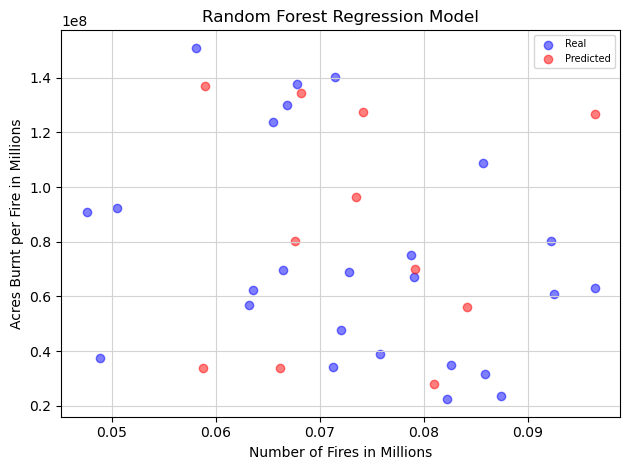

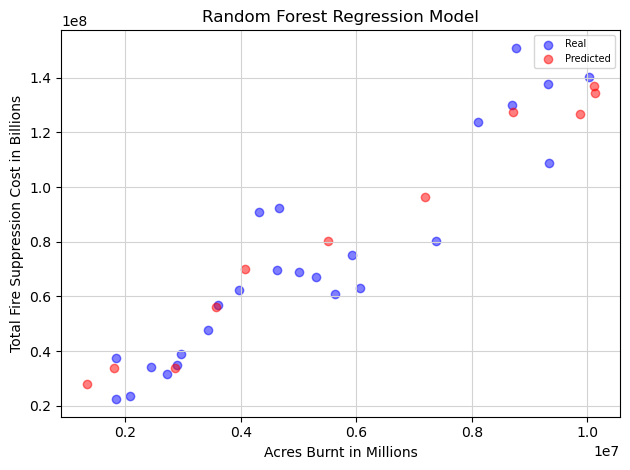

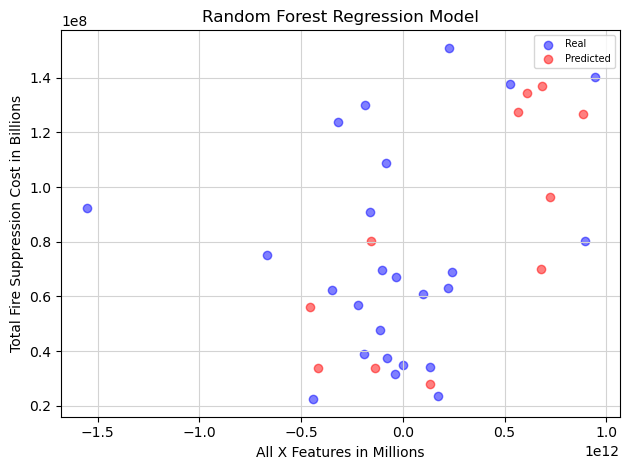

In [13]:
# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed.
X_train_1 = X_train.iloc[:, 0]
X_test_1 = X_test.iloc[:, 0]

# Scatter plot
plt.scatter(X_train_1, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_1, y_pred_1, label='Predicted', color='r', alpha=0.5)
plt.title('Random Forest Regression Model')
plt.xlabel('Number of Fires in Millions')
plt.ylabel('Acres Burnt per Fire in Millions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper right')
plt.tight_layout()
plt.show()

# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed.
X_train_1 = X_train.iloc[:, 1]
X_test_1 = X_test.iloc[:, 1]

# Scatter plot
plt.scatter(X_train_1, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_1, y_pred_1, label='Predicted', color='r', alpha=0.5)
plt.title('Random Forest Regression Model')
plt.xlabel('Acres Burnt in Millions')
plt.ylabel('Total Fire Suppression Cost in Billions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper right')
plt.tight_layout()
plt.show()

# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed.
X_train_1 = X_train.iloc[:, 4]
X_test_1 = X_test.iloc[:, 4]

# Scatter plot
plt.scatter(X_train_1, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_1, y_pred_1, label='Predicted', color='r', alpha=0.5)
plt.title('Random Forest Regression Model')
plt.xlabel('All X Features in Millions')
plt.ylabel('Total Fire Suppression Cost in Billions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper right')
plt.tight_layout()
plt.show()

In [14]:
# Find the best parameters for the model
parameters = {
    'max_depth': [2, 3, 4, 5, 10, 20, 30, 40],
    'n_estimators': [5, 10, 20, 30, 40, 50, 100]}

#gridforest = GridSearchCV(model_1, parameters, cv=5, n_jobs=-1, verbose=1)
gridforest = GridSearchCV(model_1, parameters, cv=5, verbose=1)
gridforest.fit(X_train, y_train)
print('The best paramters are:', gridforest.best_params_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters are: {'max_depth': 4, 'n_estimators': 20}


In [15]:
# Gauge feature importances
# Get features list ('Fires' and 'Acres Burnt')
features = X.columns

# Get the variables importances, sort them, and print the result
importances = list(model_1.feature_importances_)
features_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
features_importances = sorted(features_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:30} Importance: {}'.format(*pair)) for pair in features_importances];

Feature: Acres Burnt                    Importance: 0.8607
Feature: Total Fire Suppression Cost    Importance: 0.0591
Feature: Suppression Cost per Fire      Importance: 0.0518
Feature: Year over Year Change in Fire Suppression Cost Importance: 0.0152
Feature: Fires                          Importance: 0.0132


### KNN Regression ###

In [16]:
# Implement KNN Regression Model

# Create KNeighbors Regression object
model_2 = KNeighborsRegressor(n_neighbors=5)

# Train KNeighborsRegressor
model_2.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_2 = model_2.predict(X_test)

In [17]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_2), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_2), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_2, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_2), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_2), '.4f'))

Mean Absolute Error (MAE): 24109897.0195
Mean Squared Error (MSE): 901929285758185.5000
Root Mean Squared Error (RMSE): 30032137.5489
Mean Absolute Percentage Error (MAPE): 0.3979
R Squared: 0.6081


With MAE in mind, the average estimate is off by 24,109,897.02 which is very high. Its MAPE is the greatest of the models tested. An R Squared or classification rate of 60.81% is considered poor accuracy. It is clear that this model will not be used.

In [18]:
# Find the optimal k value by leveraging RMSE + store RMSE values for varying k values
rmse_value = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    error = format(sqrt(mean_squared_error(y_test, prediction)), '.4f')
    rmse_value.append(error) 
    print('The RMSE value for k =' , K , 'is:', error)

The RMSE value for k = 1 is: 39378437.4256
The RMSE value for k = 2 is: 31208369.1475
The RMSE value for k = 3 is: 33568011.5516
The RMSE value for k = 4 is: 31129739.3915
The RMSE value for k = 5 is: 30032137.5489
The RMSE value for k = 6 is: 30979308.9347
The RMSE value for k = 7 is: 32322811.2042
The RMSE value for k = 8 is: 33281738.3133
The RMSE value for k = 9 is: 33092908.0283
The RMSE value for k = 10 is: 33045389.7677


The optimal K value is found at K = 5.

### Decision Tree Regression ###

In [19]:
# Implement Decision Tree Regression Model
X_train_3 = X_train.iloc[:, 0]
X_test_3 = X_test.iloc[:, 0]

# Create Decision Tree Regression object
model_3 = DecisionTreeRegressor()
model_3.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_3 = model_3.predict(X_test)

In [20]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_3), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_3), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_3, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_3), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_3), '.4f'))

Mean Absolute Error (MAE): 15223344.2245
Mean Squared Error (MSE): 317361779960526.4375
Root Mean Squared Error (RMSE): 17814650.7112
Mean Absolute Percentage Error (MAPE): 0.2464
R Squared: 0.8621


With MAE in mind, the average estimate is off by 17,783,687.56. An R Squared or classification rate of 81.53% is considered good accuracy.

In [21]:
# Gauge feature importances
# Get features list
features = X.columns

# Get each feature's importance value
importances = list(model_3.feature_importances_)
features_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
features_importances = sorted(features_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:30} Importance: {}'.format(*pair)) for pair in features_importances];

Feature: Acres Burnt                    Importance: 0.9276
Feature: Fires                          Importance: 0.0379
Feature: Total Fire Suppression Cost    Importance: 0.0257
Feature: Year over Year Change in Fire Suppression Cost Importance: 0.0086
Feature: Suppression Cost per Fire      Importance: 0.0002


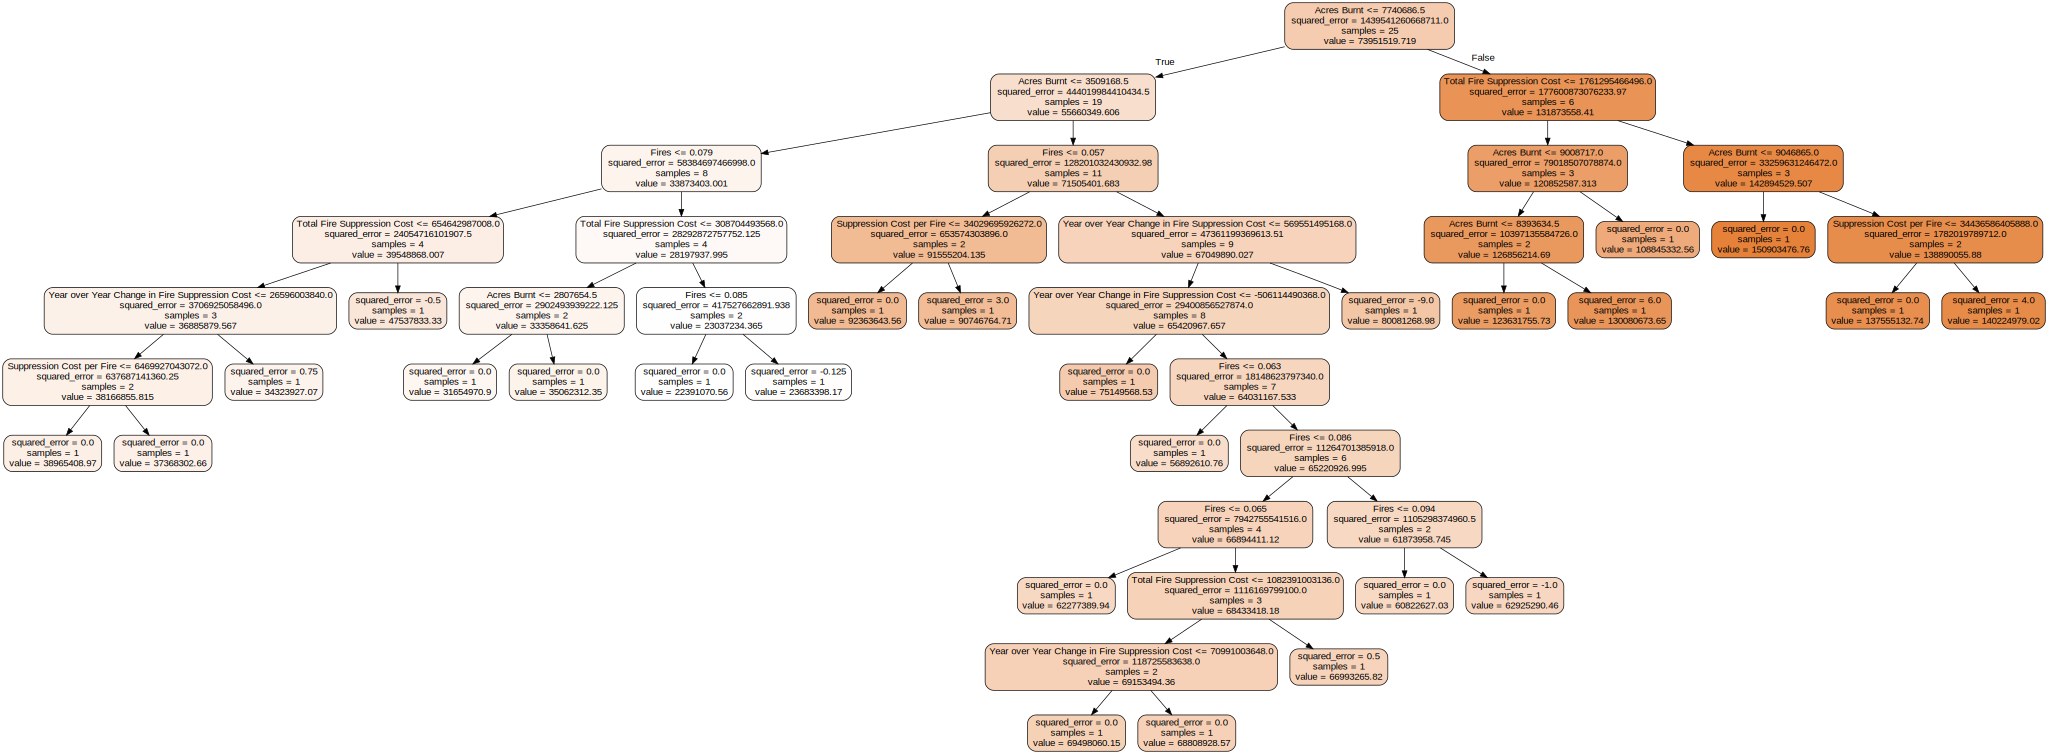

In [22]:
# View decision tree + export the decision tree to a tree.dot file to visualize
dot_data = tree.export_graphviz(model_3, out_file=None, feature_names=['Fires', 'Acres Burnt', 
                                'Total Fire Suppression Cost', 'Suppression Cost per Fire', 
                                'Year over Year Change in Fire Suppression Cost'], filled=True, rounded=True)
graph = graphviz.Source(dot_data, format="png") 
graph

### Linear Regression ###

In [23]:
# Implement Linear Regression Model
model_4 = LinearRegression()
model_4.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_4 = model_4.predict(X_test)

In [24]:
print('Mean Absolute Error (MAE):', format(metrics.mean_absolute_error(y_test, y_pred_4), '.4f'))
print('Mean Squared Error (MSE):', format(metrics.mean_squared_error(y_test, y_pred_4), '.4f'))
print('Root Mean Squared Error (RMSE):', format(metrics.mean_squared_error(y_test, y_pred_4, squared=False), '.4f'))
print('Mean Absolute Percentage Error (MAPE):', format(metrics.mean_absolute_percentage_error(y_test, y_pred_4), '.4f'))
print('R Squared:', format(metrics.r2_score(y_test, y_pred_4), '.4f'))

Mean Absolute Error (MAE): 3576179.0093
Mean Squared Error (MSE): 25540960443605.5547
Root Mean Squared Error (RMSE): 5053806.5301
Mean Absolute Percentage Error (MAPE): 0.0635
R Squared: 0.9889


With MAE in mind, the average estimate is off by 3,576,179.01 which is the lowest of the models tested. Its MAPE is also the lowest of the models tested. An R Squared or classification rate of 98.89% is considered great accuracy.

In [25]:
# Gauge feature importances
# Get features list
features = X.columns

# Get the each feature's coefficient value
importances = list(model_4.coef_)
features_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
features_importances = sorted(features_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:30} Coefficients: {}'.format(*pair)) for pair in features_importances];

Feature: Acres Burnt                    Coefficients: 14.2753
Feature: Total Fire Suppression Cost    Coefficients: -0.0
Feature: Suppression Cost per Fire      Coefficients: 0.0
Feature: Year over Year Change in Fire Suppression Cost Coefficients: 0.0
Feature: Fires                          Coefficients: -514613219.3392


In [26]:
# Look at shapes of training and test shapes to ensure they align for graphing + visualizing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred_4.shape)

(25, 5)
(25,)
(11, 5)
(11,)
(11,)


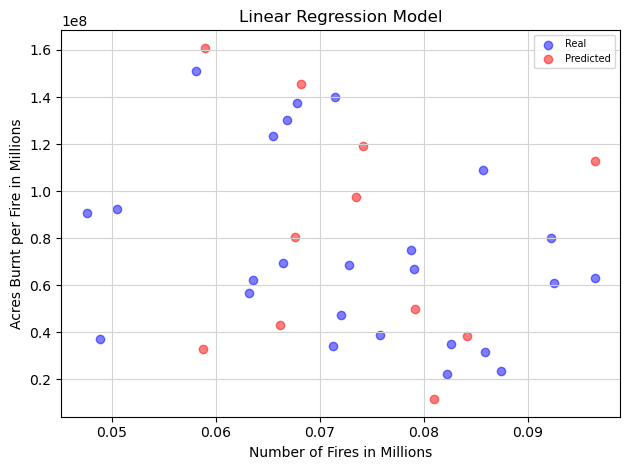

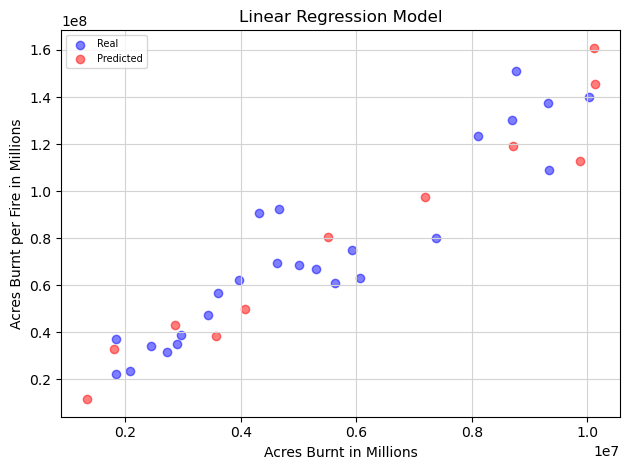

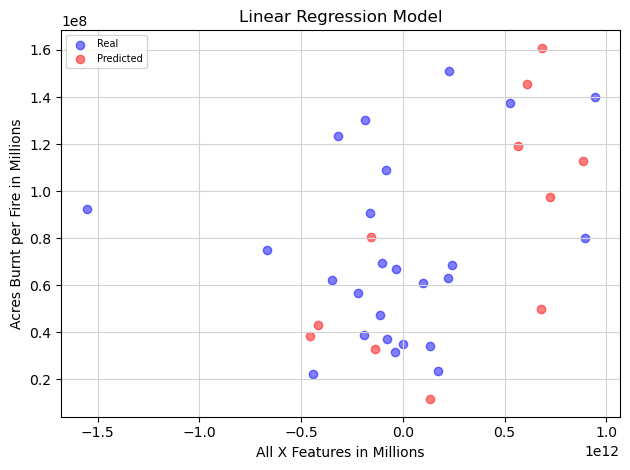

In [27]:
# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed. Showing them = 'Fires.'
X_train_4 = X_train.iloc[:, 0]
X_test_4= X_test.iloc[:, 0]

# Scatter plot
plt.scatter(X_train_4, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_4, y_pred_4, label='Predicted', color='r', alpha=0.5)
plt.title('Linear Regression Model')
plt.xlabel('Number of Fires in Millions')
plt.ylabel('Acres Burnt per Fire in Millions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper right')
plt.tight_layout()
plt.show()

# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed. Showing them = 'Acres Burnt.'
X_train_4 = X_train.iloc[:, 1]
X_test_4 = X_test.iloc[:, 1]

# Scatter plot
plt.scatter(X_train_4, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_4, y_pred_4, label='Predicted', color='r', alpha=0.5)
plt.title('Linear Regression Model')
plt.xlabel('Acres Burnt in Millions')
plt.ylabel('Acres Burnt per Fire in Millions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

# Adjust X_train and X_test shape size as their current shapes differ, so they cannot be graphed. Showing them = 'Acres Burnt.'
X_train_4 = X_train.iloc[:, 4]
X_test_4 = X_test.iloc[:, 4]

# Scatter plot
plt.scatter(X_train_4, y_train, label='Real', color='b', alpha=0.5)
plt.scatter(X_test_4, y_pred_4, label='Predicted', color='r', alpha=0.5)
plt.title('Linear Regression Model')
plt.xlabel('All X Features in Millions')
plt.ylabel('Acres Burnt per Fire in Millions')
plt.grid(color='#D3D3D3', linestyle='solid')
plt.legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

## Takeaways ##

Three models performed very simialarly which came as a surprise while the other did not, so it will be disregarded.

Below are model performance results:
1. Random Forest (model_1)
    - Root Mean Squared Error (RMSE): 16,103,675.23
    - Mean Absolute Percentage Error (MAPE): 0.2147
    - R Squared: 88.73%
2. KNN Regression (model_2)
    - Root Mean Squared Error (RMSE): 30,032,137.55
    - Mean Absolute Percentage Error (MAPE): 0.3979
    - R Squared: 60.81%
3. Decision Tree (model_3)
    - Root Mean Squared Error (RMSE): 20,615,589.49
    - Mean Absolute Percentage Error (MAPE): 0.2598
     - R Squared: 81.53%
4. Linear Regression (model_4)
    - Root Mean Squared Error (RMSE): 5,053,806.5
    - Mean Absolute Percentage Error (MAPE): 0.0635
    - R Squared: 98.89%

The Linear Regression model performed the best, so it will be leveraged.